In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [3]:
def visualize_model(model, dataloaders, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [4]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25, is_inception=False, scheduler=None):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                scheduler.step()                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [5]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
#         model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft.fc = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(num_ftrs, num_classes)
                                   )
        input_size = 224
        
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
#         model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft.fc = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(num_ftrs, num_classes)
                                   )
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_1(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
#         model_ft.fc = nn.Linear(num_ftrs,num_classes)
        model_ft.fc = nn.Sequential(nn.Dropout(0.5),
                                 nn.Linear(num_ftrs, num_classes)
                                )
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [6]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_NAME = 'resnet152'
BATCH_SIZE = 16
NUM_WORKERS = 6
NUM_EPOCHS = 30

In [7]:
data_transforms = {'train': transforms.Compose([transforms.Resize(256),
                                                transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomVerticalFlip(),
                                                transforms.RandomRotation(45),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                               ]),
                   'val': transforms.Compose([transforms.Resize(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                             ])
                  }


split_1_dir = 'out/cnn/train/synthetic/'
split_1_datasets = {x: datasets.ImageFolder(os.path.join(split_1_dir, x), data_transforms[x]) for x in ['train', 'val']}
split_1_dataloaders = {x: torch.utils.data.DataLoader(split_1_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True) for x in ['train', 'val']}
split_1_sizes = {x: len(split_1_datasets[x]) for x in ['train', 'val']}


class_names = split_1_datasets['train'].classes

num_classes = len(class_names)

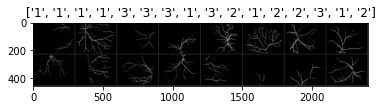

In [8]:
inputs, classes = next(iter(split_1_dataloaders['val']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
model_ft, input_size = initialize_model(MODEL_NAME, num_classes, use_pretrained=True)
model_ft = model_ft.to(DEVICE)

params_to_update = model_ft.parameters()
# print("Params to learn:")
# for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
# optimizer_ft = optim.Adam(params_to_update)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=NUM_EPOCHS//6, gamma=0.5, last_epoch=-1, verbose=True)


weight = torch.tensor([4965/973, 4965/4190, 4965/4965]).to(DEVICE)
print(weight)
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, split_1_dataloaders, criterion, optimizer_ft, device=DEVICE, num_epochs=NUM_EPOCHS, is_inception=(MODEL_NAME=="inception"), scheduler=scheduler)

Adjusting learning rate of group 0 to 1.0000e-02.
tensor([5.1028, 1.1850, 1.0000], device='cuda:0')
Epoch 0/29
----------
train Loss: 1.1450 Acc: 0.4844
val Loss: 1.2174 Acc: 0.4467
Adjusting learning rate of group 0 to 1.0000e-02.

Epoch 1/29
----------
train Loss: 0.9255 Acc: 0.5326
val Loss: 1.0688 Acc: 0.4200
Adjusting learning rate of group 0 to 1.0000e-02.

Epoch 2/29
----------
train Loss: 0.8722 Acc: 0.5834
val Loss: 1.1145 Acc: 0.4333
Adjusting learning rate of group 0 to 1.0000e-02.

Epoch 3/29
----------
train Loss: 0.7764 Acc: 0.6474
val Loss: 0.7549 Acc: 0.5267
Adjusting learning rate of group 0 to 1.0000e-02.

Epoch 4/29
----------
train Loss: 0.6890 Acc: 0.6905
val Loss: 0.7874 Acc: 0.5533
Adjusting learning rate of group 0 to 5.0000e-03.

Epoch 5/29
----------
train Loss: 0.6498 Acc: 0.7161
val Loss: 0.7382 Acc: 0.6600
Adjusting learning rate of group 0 to 5.0000e-03.

Epoch 6/29
----------
train Loss: 0.6401 Acc: 0.7161
val Loss: 0.6897 Acc: 0.6333
Adjusting learning r

In [12]:
torch.save(model_ft.state_dict(), './out/cnn/model.pth')

In [13]:
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

test_dir = 'out/cnn/test/real/'
test_datasets = datasets.ImageFolder(test_dir, test_transforms)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [29]:
model_ft, input_size = initialize_model(MODEL_NAME, num_classes, use_pretrained=True)
model_ft = model_ft.to(DEVICE)

model_ft.load_state_dict(torch.load('./out/cnn/model.pth'))

model_ft.fc = nn.Sequential(*model_ft.fc,
                            nn.Softmax(dim=1),
                           )

In [64]:
model_ft.eval()

running_loss = 0.0
running_corrects = 0

probs = []
all_preds = []
all_labels = []

for inputs, labels in test_dataloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer_ft.zero_grad()

    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)
        
        probs.extend(outputs.detach().cpu().tolist())
        all_labels.extend(labels.detach().cpu().tolist())
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.detach().cpu().tolist())

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

epoch_loss = running_loss / len(test_dataloader.dataset)
epoch_acc = running_corrects.double() / len(test_dataloader.dataset)

print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))

test Loss: 0.8734 Acc: 0.7041


In [65]:
np.savetxt('./out/cnn/all_preds.csv', all_preds)
np.savetxt('./out/cnn/all_labels.csv', all_labels)
np.savetxt('./out/cnn/probs.csv', probs, delimiter =", ")